# Домашнее задание № 9

### Задание 1 (10 баллов).
Это задание основано на этой тетрадке - https://github.com/mannefedov/compling_nlp_hse_course/blob/master/notebooks/transfer_learning_hg/Fine_tunining_pretrained_LMs_torch.ipynb

На датасете lenta_sample.ru  дообучите две модели - modernbert-base (из семинара) и rumodernbert-base (https://huggingface.co/deepvk/RuModernBERT-base). Оцените разницу в качестве сравнив поклассовые метрики (classification_report)

Для обоих моделей качество должно быть >0.10 по f-мере (прогоните несколько экспериментов если у вас получаются нули, изменяя параметры).
Также для обоих моделей попробуйте дообучать модель и целиком и дообучать только последний слой. 
Для RuModernBERT дополнительно сравните модель, которая использует первый вектор (cls токен, как в семинаре), так и усредненный вектор по всем hidden_state, который выдает bert. 




In [1]:
import pandas as pd
from transformers import AutoModel
from transformers import AutoTokenizer
import torch

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

import numpy as np
from tqdm import tqdm

from string import punctuation

/home/smertlove/sandbox/hse/nlp_hw/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
data = pd.read_csv('./data/lenta_sample.csv')
data.dropna(subset=['topic', 'text'], inplace=True)

In [4]:
data.head(3)

,url,title,text,topic,tags,date
0,https://lenta.ru/news/2010/12/16/passports/,Московская милиция ужесточила паспортный режим,В Москве после серии массовых беспорядков на н...,Россия,Все,2010/12/16
1,https://lenta.ru/news/2014/05/19/student/,Московского студента ограбили на 6 миллионов р...,Неизвестные вынесли из квартиры московского ст...,Россия,NaN,2014/05/19
2,https://lenta.ru/news/2008/09/27/catch/,В Ставропольском крае обезврежены боевики,"В Ставропольском крае задержаны боевики, котор...",Россия,Все,2008/09/27


In [5]:
data.topic.value_counts()

topic
Из жизни             55
Наука и техника      54
Бывший СССР          54
Культура             53
Ценности             45
Дом                  45
Бизнес               44
Интернет и СМИ       44
Силовые структуры    40
Спорт                39
Россия               32
Экономика            32
Мир                  27
69-я параллель       13
Легпром              13
Библиотека           10
Крым                  7
Name: count, dtype: int64

In [6]:
data.shape

(607, 6)

In [7]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, tokenizer, MAX_LEN, texts, targets):
        
        self.tokenizer = tokenizer
        self.texts = [torch.LongTensor(tokenizer.encode(t)[:MAX_LEN]) for t in texts]
        self.texts = torch.nn.utils.rnn.pad_sequence(self.texts, batch_first=True,
                                                     padding_value=self.tokenizer.pad_token_id)
        
        self.MAX_LEN = MAX_LEN
        self.length = len(texts)
        
        self.target = torch.LongTensor(targets)

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        ids = self.texts[index]
        y = self.target[index]

        return ids, y
    
    def preprocess(self, text):
        tokens = text.lower().split()
        tokens = [token.strip(punctuation) for token in tokens]
        tokens = [token for token in tokens if token]
        return tokens

In [8]:
MAX_LEN = 512

In [11]:

texts = data.text.values
id2label = {i:l for i,l in enumerate(set(data["topic"]))}
label2id = {l:i for i,l in id2label.items()}
targets = [label2id[l] for l in data["topic"]]

In [12]:
train_texts, valid_texts, train_targets, valid_targets = train_test_split(texts, targets, test_size=0.05)

### ModernBERT c заморозкой

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data

from sklearn.metrics import f1_score

In [14]:
import torch.nn as nn

class CLF(nn.Module):
    
    def __init__(self, tokenizer, model, num_classes):
        super().__init__()          
        self.tokenizer = tokenizer # токенизатор
        self.pretrained_model = model # предобученная модель
        #
        self.drop = nn.Dropout(0.3) # добавим дропаут чтобы не переобучалось
        self.fc = nn.Linear(768, num_classes) 
        self.act = nn.LogSoftmax(1) 
        
    def forward(self, texts):
        
        mask = (texts != self.tokenizer.pad_token_id).long()
        
        # прогоняем через BERT
        hidden = self.pretrained_model(texts, attention_mask=mask)[0]

        # берем самое первое состояние и применяем к нему линейный слой и активацию
        dense_outputs=self.fc(self.drop(hidden[:,0] ))
        outputs=self.act(dense_outputs)
        
        return outputs

In [39]:
model_id = "answerdotai/ModernBERT-base"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model_bert = AutoModel.from_pretrained(model_id)

for param in model_bert.parameters():
    param.requires_grad = False

In [ ]:
training_set = Dataset(tokenizer, MAX_LEN, train_texts, train_targets)
training_generator = torch.utils.data.DataLoader(training_set, batch_size=16, shuffle=True, )
valid_set = Dataset(tokenizer, MAX_LEN, valid_texts, valid_targets)
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=16, shuffle=True)

In [42]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
model = CLF(tokenizer, model_bert, len(label2id))
optimizer = optim.Adam(model.parameters(), lr=2e-4)
criterion = nn.NLLLoss() 
model = model.to(device)
criterion = criterion.to(device)

In [43]:
print("Percentage of trainable params:")
print('{0:.10f}'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)/sum(p.numel() for p in model.parameters())))

Percentage of trainable params:
0.0000877222


In [15]:
def train(model, iterator, optimizer, criterion, print_every=1000):
    
    epoch_loss = []
    epoch_f1 = []
    
    model.train()

    for i, (texts, ys) in enumerate(iterator):

        optimizer.zero_grad()   
        predictions = model(texts.to(device)).squeeze()  
        loss = criterion(predictions, ys.to(device))        

        loss.backward()
        optimizer.step()     
        preds = predictions.detach().to('cpu').numpy().argmax(1).tolist()
        y_true = ys.tolist()
        
        epoch_loss.append(loss.item())
        epoch_f1.append(f1_score(y_true, preds, average="micro"))
        
        if not (i+1) % print_every:
            print(f'Loss: {np.mean(epoch_loss)}; F1 measure: {np.mean(epoch_f1)}')
        
    return np.mean(epoch_f1)


def evaluate(model, iterator, criterion):
    
    epoch_loss = []
    epoch_f1 = []
    
    model.eval()  
    with torch.no_grad():
        for texts, ys in iterator:   

            predictions = model(texts.to(device)).squeeze()  
            loss = criterion(predictions, ys.to(device))        
            preds = predictions.detach().to('cpu').numpy().argmax(1).tolist()
            y_true = ys.tolist()
            

            epoch_loss.append(loss.item())  
            epoch_f1.append(f1_score(y_true, preds, average="micro"))
            
    return np.mean(epoch_f1)# / len(iterator)

In [16]:
def predict(model, iterator):
    
    preds = []
    
    model.eval()  
    with torch.no_grad():
        for texts, ys in iterator:   
            predictions = model(texts.to(device)).squeeze()        
            ys = predictions.detach().to('cpu').numpy().argmax(1).tolist()
            preds.extend(ys)
            
    return preds

In [45]:
f1s = []
f1s_eval = []

for i in range(40):
    print(i)
    f1s.append(train(model, training_generator, optimizer, criterion, 2000))
    evl = evaluate(model, valid_generator, criterion)
    print('Eval - ', evl)
    f1s_eval.append(evl)

0


/home/smertlove/sandbox/hse/nlp_hw/.venv/lib/python3.10/site-packages/torch/_inductor/compile_fx.py:167: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(


Eval -  0.12708333333333333
1
Eval -  0.16666666666666666
2
Eval -  0.1625
3
Eval -  0.32291666666666663
4
Eval -  0.25416666666666665
5
Eval -  0.29166666666666663
6
Eval -  0.2895833333333333
7
Eval -  0.3208333333333333
8
Eval -  0.325
9
Eval -  0.31875
10
Eval -  0.22916666666666666
11
Eval -  0.325
12
Eval -  0.29375
13
Eval -  0.325
14
Eval -  0.2895833333333333
15
Eval -  0.25625
16
Eval -  0.35625
17
Eval -  0.3208333333333333
18
Eval -  0.2625
19
Eval -  0.25625
20
Eval -  0.22708333333333333
21
Eval -  0.29166666666666663
22
Eval -  0.2895833333333333
23
Eval -  0.25625
24
Eval -  0.2895833333333333
25
Eval -  0.3208333333333333
26
Eval -  0.2583333333333333
27
Eval -  0.26041666666666663
28
Eval -  0.225
29
Eval -  0.3208333333333333
30
Eval -  0.2875
31
Eval -  0.28541666666666665
32
Eval -  0.32291666666666663
33
Eval -  0.2583333333333333
34
Eval -  0.2833333333333333
35
Eval -  0.2895833333333333
36
Eval -  0.2625
37
Eval -  0.325
38
Eval -  0.2583333333333333
39
Eval - 

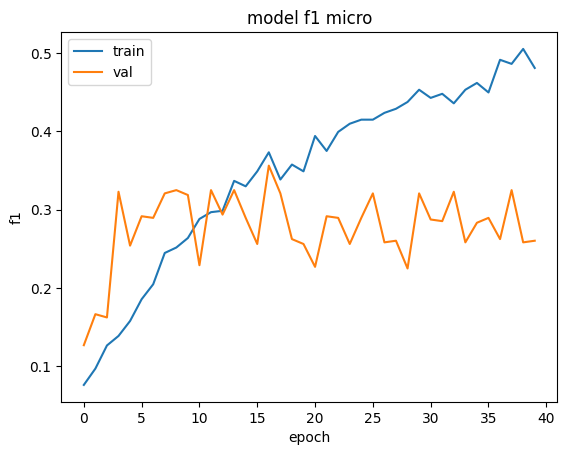

In [47]:

plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('model f1 micro')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [49]:
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=False)
preds = predict(model, valid_generator)

In [51]:
label2id

{'Спорт': 0,
 'Бывший СССР': 1,
 'Экономика': 2,
 'Бизнес': 3,
 'Россия': 4,
 'Культура': 5,
 'Мир': 6,
 'Крым': 7,
 'Из жизни': 8,
 'Силовые структуры': 9,
 'Ценности': 10,
 '69-я параллель': 11,
 'Библиотека': 12,
 'Легпром': 13,
 'Дом': 14,
 'Наука и техника': 15,
 'Интернет и СМИ': 16}

In [54]:
len(label2id.keys())

17

In [58]:

print(classification_report(valid_targets, preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         0
           2       0.67      0.67      0.67         3
           3       0.25      0.33      0.29         3
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         2
           7       0.00      0.00      0.00         0
           8       0.17      0.33      0.22         3
           9       0.67      0.33      0.44         6
          11       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         1
          14       0.67      0.40      0.50         5
          15       0.00      0.00      0.00         1
          16       0.00      0.00      0.00         1

    accuracy                           0.26        31
   macro avg       0.15   

/home/smertlove/sandbox/hse/nlp_hw/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/smertlove/sandbox/hse/nlp_hw/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/smertlove/sandbox/hse/nlp_hw/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric

### ModernBERT без заморозки

In [12]:

model_id = "answerdotai/ModernBERT-base"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model_bert = AutoModel.from_pretrained(model_id)

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
model = CLF(tokenizer, model_bert, len(label2id))
optimizer = optim.Adam(model.parameters(), lr=2e-4)
criterion = nn.NLLLoss() 
model = model.to(device)
criterion = criterion.to(device)

In [14]:
print("Percentage of trainable params:")
print('{0:.10f}'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)/sum(p.numel() for p in model.parameters())))

Percentage of trainable params:
1.0000000000


In [19]:
training_set = Dataset(tokenizer, MAX_LEN, train_texts, train_targets)
training_generator = torch.utils.data.DataLoader(training_set, batch_size=8, shuffle=True, )  # уменьшил батчсайз тк не влезал (cuda out of memory)
valid_set = Dataset(tokenizer, MAX_LEN, valid_texts, valid_targets)
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=8, shuffle=True)  # уменьшил батчсайз тк не влезал (cuda out of memory)

In [20]:
f1s = []
f1s_eval = []

for i in range(30):
    print(i)
    f1s.append(train(model, training_generator, optimizer, criterion, 2000))
    evl = evaluate(model, valid_generator, criterion)
    print('Eval - ', evl)
    f1s_eval.append(evl)

0
Eval -  0.09821428571428571
1
Eval -  0.10267857142857142
2
Eval -  0.03125
3
Eval -  0.09821428571428571
4
Eval -  0.03571428571428571
5
Eval -  0.13392857142857142
6
Eval -  0.15625
7
Eval -  0.16517857142857142
8
Eval -  0.32589285714285715
9
Eval -  0.1607142857142857
10
Eval -  0.26339285714285715
11
Eval -  0.22767857142857142
12
Eval -  0.29464285714285715
13
Eval -  0.19642857142857142
14
Eval -  0.2232142857142857
15
Eval -  0.2589285714285714
16
Eval -  0.1875
17
Eval -  0.2232142857142857
18
Eval -  0.2901785714285714
19
Eval -  0.32589285714285715
20
Eval -  0.2857142857142857
21
Eval -  0.22767857142857142
22
Eval -  0.2589285714285714
23
Eval -  0.2589285714285714
24
Eval -  0.2589285714285714
25
Eval -  0.2589285714285714
26
Eval -  0.2544642857142857
27
Eval -  0.2544642857142857
28
Eval -  0.2589285714285714
29
Eval -  0.2589285714285714


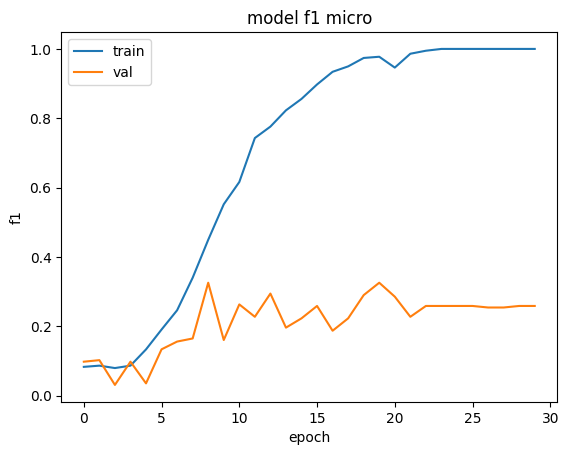

In [25]:

plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('model f1 micro')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [22]:
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=False)
preds = predict(model, valid_generator)

In [23]:
print(classification_report(valid_targets, preds))

              precision    recall  f1-score   support

           0       0.50      0.50      0.50         2
           1       1.00      0.40      0.57         5
           2       0.75      0.75      0.75         4
           3       0.33      0.33      0.33         3
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         3
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         2
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         2
          13       0.00      0.00      0.00         3
          14       0.20      0.50      0.29         2
          15       0.00      0.00      0.00         1

    accuracy                           0.26        31
   macro avg       0.17   

/home/smertlove/sandbox/hse/nlp_hw/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/smertlove/sandbox/hse/nlp_hw/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/smertlove/sandbox/hse/nlp_hw/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric

### RuModernBERT с заморозкой

In [26]:
model_id = "deepvk/RuModernBERT-base"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model_bert = AutoModel.from_pretrained(model_id)

for param in model_bert.parameters():
    param.requires_grad = False

In [27]:
training_set = Dataset(tokenizer, MAX_LEN, train_texts, train_targets)
training_generator = torch.utils.data.DataLoader(training_set, batch_size=16, shuffle=True, )
valid_set = Dataset(tokenizer, MAX_LEN, valid_texts, valid_targets)
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=16, shuffle=True)

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
model = CLF(tokenizer, model_bert, len(label2id))
optimizer = optim.Adam(model.parameters(), lr=2e-4)
criterion = nn.NLLLoss() 
model = model.to(device)
criterion = criterion.to(device)

In [29]:
print("Percentage of trainable params:")
print('{0:.10f}'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)/sum(p.numel() for p in model.parameters())))

Percentage of trainable params:
0.0000877222


In [30]:
f1s = []
f1s_eval = []

for i in range(40):
    print(i)
    f1s.append(train(model, training_generator, optimizer, criterion, 2000))
    evl = evaluate(model, valid_generator, criterion)
    print('Eval - ', evl)
    f1s_eval.append(evl)

0
Eval -  0.09375
1
Eval -  0.09583333333333333
2
Eval -  0.09583333333333333
3
Eval -  0.12708333333333333
4
Eval -  0.0625
5
Eval -  0.09375
6
Eval -  0.1
7
Eval -  0.09791666666666667
8
Eval -  0.12916666666666665
9
Eval -  0.1625
10
Eval -  0.09583333333333333
11
Eval -  0.13125
12
Eval -  0.12916666666666665
13
Eval -  0.09375
14
Eval -  0.09583333333333333
15
Eval -  0.19375
16
Eval -  0.13125
17
Eval -  0.16041666666666665
18
Eval -  0.1
19
Eval -  0.1625
20
Eval -  0.1625
21
Eval -  0.12916666666666665
22
Eval -  0.12708333333333333
23
Eval -  0.12708333333333333
24
Eval -  0.19166666666666665
25
Eval -  0.1625
26
Eval -  0.12708333333333333
27
Eval -  0.13125
28
Eval -  0.13125
29
Eval -  0.19166666666666665
30
Eval -  0.16041666666666665
31
Eval -  0.12708333333333333
32
Eval -  0.19166666666666665
33
Eval -  0.13125
34
Eval -  0.16041666666666665
35
Eval -  0.1625
36
Eval -  0.19166666666666665
37
Eval -  0.12916666666666665
38
Eval -  0.19166666666666665
39
Eval -  0.164583

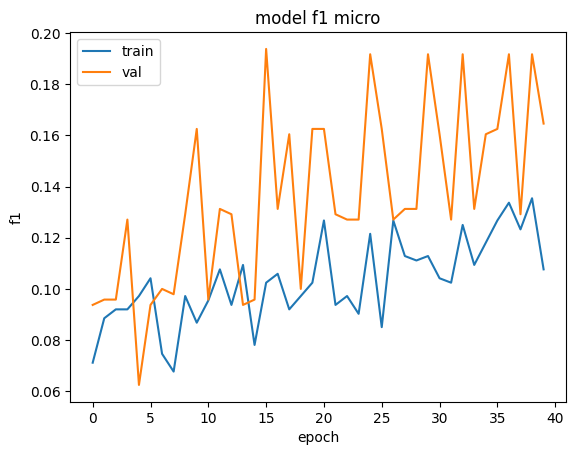

In [31]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('model f1 micro')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [32]:
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=False)
preds = predict(model, valid_generator)

In [33]:
print(classification_report(valid_targets, preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       1.00      0.20      0.33         5
           2       0.00      0.00      0.00         4
           3       0.11      0.33      0.17         3
           4       0.00      0.00      0.00         1
           5       0.10      0.67      0.17         3
           7       0.00      0.00      0.00         2
           9       0.00      0.00      0.00         2
          10       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         2
          13       1.00      0.33      0.50         3
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         1

    accuracy                           0.16        31
   macro avg       0.17      0.12      0.09        31
weighted avg       0.28      0.16      0.14        31



/home/smertlove/sandbox/hse/nlp_hw/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/smertlove/sandbox/hse/nlp_hw/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/smertlove/sandbox/hse/nlp_hw/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

### RuModernBERT без заморозки

In [17]:
model_id = "deepvk/RuModernBERT-base"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model_bert = AutoModel.from_pretrained(model_id)

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
model = CLF(tokenizer, model_bert, len(label2id))
optimizer = optim.Adam(model.parameters(), lr=2e-4)
criterion = nn.NLLLoss() 
model = model.to(device)
criterion = criterion.to(device)

In [19]:
print("Percentage of trainable params:")
print('{0:.10f}'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)/sum(p.numel() for p in model.parameters())))

Percentage of trainable params:
1.0000000000


In [20]:
training_set = Dataset(tokenizer, MAX_LEN, train_texts, train_targets)
training_generator = torch.utils.data.DataLoader(training_set, batch_size=8, shuffle=True, )  # уменьшил батчсайз тк не влезал (cuda out of memory)
valid_set = Dataset(tokenizer, MAX_LEN, valid_texts, valid_targets)
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=8, shuffle=True)  # уменьшил батчсайз тк не влезал (cuda out of memory)

In [21]:
f1s = []
f1s_eval = []

for i in range(30):
    print(i)
    f1s.append(train(model, training_generator, optimizer, criterion, 2000))
    evl = evaluate(model, valid_generator, criterion)
    print('Eval - ', evl)
    f1s_eval.append(evl)

0
Eval -  0.09375
1
Eval -  0.1607142857142857
2
Eval -  0.09821428571428571
3
Eval -  0.16517857142857142
4
Eval -  0.125
5
Eval -  0.3214285714285714
6
Eval -  0.42410714285714285
7
Eval -  0.38839285714285715
8
Eval -  0.2589285714285714
9
Eval -  0.42410714285714285
10
Eval -  0.39285714285714285
11
Eval -  0.3839285714285714
12
Eval -  0.3526785714285714
13
Eval -  0.3973214285714286
14
Eval -  0.38839285714285715
15
Eval -  0.3839285714285714
16
Eval -  0.38839285714285715
17
Eval -  0.39285714285714285
18
Eval -  0.38839285714285715
19
Eval -  0.3839285714285714
20
Eval -  0.3839285714285714
21
Eval -  0.3839285714285714
22
Eval -  0.3839285714285714
23
Eval -  0.3839285714285714
24
Eval -  0.3839285714285714
25
Eval -  0.38839285714285715
26
Eval -  0.39285714285714285
27
Eval -  0.38839285714285715
28
Eval -  0.38839285714285715
29
Eval -  0.3794642857142857


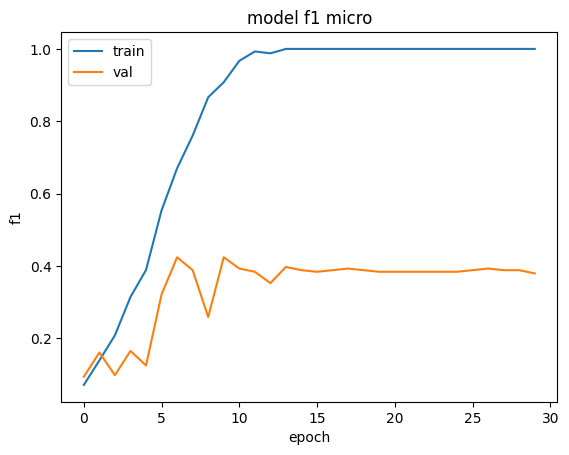

In [22]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('model f1 micro')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [23]:
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=False)
preds = predict(model, valid_generator)

In [24]:
print(classification_report(valid_targets, preds))

              precision    recall  f1-score   support

           0       0.50      0.33      0.40         3
           1       0.00      0.00      0.00         3
           2       0.50      0.25      0.33         4
           4       0.00      0.00      0.00         3
           5       0.12      1.00      0.22         1
           6       0.50      0.25      0.33         4
           7       0.33      1.00      0.50         1
           8       1.00      0.75      0.86         4
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         1
          11       1.00      1.00      1.00         1
          12       0.00      0.00      0.00         0
          13       1.00      1.00      1.00         1
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         0
          16       0.50      1.00      0.67         2

    accuracy                           0.39        31
   macro avg       0.34   

/home/smertlove/sandbox/hse/nlp_hw/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/smertlove/sandbox/hse/nlp_hw/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/smertlove/sandbox/hse/nlp_hw/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric

### RuModernBERT с hidden states

In [39]:
class CLF_HS(nn.Module):
    
    def __init__(self, tokenizer, model, num_classes):
        super().__init__()          
        self.tokenizer = tokenizer # токенизатор
        self.pretrained_model = model # предобученная модель
        #
        self.drop = nn.Dropout(0.3) # добавим дропаут чтобы не переобучалось
        self.fc = nn.Linear(768, num_classes) 
        self.act = nn.LogSoftmax(1) 
        
    def forward(self, texts):
        mask = (texts != self.tokenizer.pad_token_id).long()
        output = self.pretrained_model(texts, attention_mask=mask, output_hidden_states=True)
        hidden_states = output.hidden_states

        pooled_output = torch.stack([torch.mean(hs.float(), dim=1) for hs in hidden_states[1:]]).mean(dim=0)

        dropped_output = self.drop(pooled_output)
        dense_outputs = self.fc(dropped_output)

        outputs = self.act(dense_outputs)
        
        return outputs

In [40]:
model_id = "deepvk/RuModernBERT-base"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model_bert = AutoModel.from_pretrained(model_id)

for param in model_bert.parameters():
    param.requires_grad = False

In [41]:
training_set = Dataset(tokenizer, MAX_LEN, train_texts, train_targets)
training_generator = torch.utils.data.DataLoader(training_set, batch_size=16, shuffle=True, )
valid_set = Dataset(tokenizer, MAX_LEN, valid_texts, valid_targets)
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=16, shuffle=True)

In [42]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
model = CLF_HS(tokenizer, model_bert, len(label2id))
optimizer = optim.Adam(model.parameters(), lr=2e-4)
criterion = nn.NLLLoss() 
model = model.to(device)
criterion = criterion.to(device)

In [43]:
print("Percentage of trainable params:")
print('{0:.10f}'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)/sum(p.numel() for p in model.parameters())))

Percentage of trainable params:
0.0000877222


In [44]:
f1s = []
f1s_eval = []

for i in range(40):
    print(i)
    f1s.append(train(model, training_generator, optimizer, criterion, 2000))
    evl = evaluate(model, valid_generator, criterion)
    print('Eval - ', evl)
    f1s_eval.append(evl)

0
Eval -  0.0625
1
Eval -  0.09791666666666667
2
Eval -  0.29166666666666663
3
Eval -  0.2875
4
Eval -  0.35416666666666663
5
Eval -  0.3833333333333333
6
Eval -  0.42083333333333334
7
Eval -  0.44791666666666663
8
Eval -  0.41875
9
Eval -  0.4875
10
Eval -  0.5166666666666666
11
Eval -  0.5833333333333333
12
Eval -  0.5770833333333334
13
Eval -  0.5791666666666666
14
Eval -  0.6520833333333333
15
Eval -  0.6083333333333334
16
Eval -  0.6145833333333333
17
Eval -  0.6083333333333334
18
Eval -  0.6104166666666666
19
Eval -  0.58125
20
Eval -  0.5791666666666666
21
Eval -  0.5791666666666666
22
Eval -  0.6145833333333333
23
Eval -  0.6125
24
Eval -  0.6104166666666666
25
Eval -  0.6166666666666667
26
Eval -  0.5770833333333334
27
Eval -  0.675
28
Eval -  0.64375
29
Eval -  0.6104166666666666
30
Eval -  0.5833333333333333
31
Eval -  0.5791666666666666
32
Eval -  0.64375
33
Eval -  0.64375
34
Eval -  0.675
35
Eval -  0.6145833333333333
36
Eval -  0.6104166666666666
37
Eval -  0.64791666666

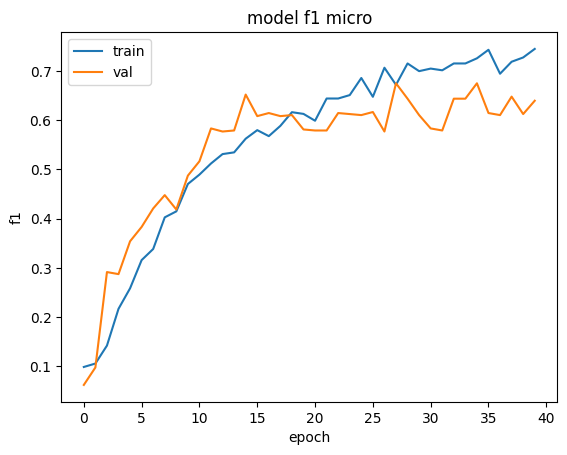

In [45]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('model f1 micro')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [46]:
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=False)
preds = predict(model, valid_generator)

In [47]:
print(classification_report(valid_targets, preds))

              precision    recall  f1-score   support

           0       0.33      0.33      0.33         3
           1       1.00      0.67      0.80         3
           2       0.50      0.25      0.33         4
           4       0.75      1.00      0.86         3
           5       0.00      0.00      0.00         1
           6       1.00      0.75      0.86         4
           7       0.25      1.00      0.40         1
           8       1.00      1.00      1.00         4
           9       0.00      0.00      0.00         1
          10       1.00      1.00      1.00         1
          11       1.00      1.00      1.00         1
          13       0.00      0.00      0.00         1
          14       0.33      0.50      0.40         2
          16       0.50      1.00      0.67         2

    accuracy                           0.65        31
   macro avg       0.55      0.61      0.55        31
weighted avg       0.65      0.65      0.62        31



/home/smertlove/sandbox/hse/nlp_hw/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/smertlove/sandbox/hse/nlp_hw/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/smertlove/sandbox/hse/nlp_hw/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

### Overview

Забавно, что f1 по accuracy для обеих моделей ModernBERT получилась <s>одинаково плохой</s> одинаковой. RuModernBERT с заморозкой показал самые плохие результаты (и график у него такой, будто ему плохо).